# 1) import des packaging : 

In [1]:
# Importations standards
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importations de scikit-learn pour le prétraitement
from sklearn.preprocessing import StandardScaler

# Importations de scikit-learn pour la modélisation
from sklearn.linear_model import LinearRegression, BayesianRidge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR


from sklearn.linear_model import Ridge, Lasso

# Importations de scikit-learn pour l'évaluation des modèles
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Importations de scikit-learn pour la validation et l'optimisation des modèles
from sklearn.model_selection import (
    train_test_split, KFold, cross_val_predict, GridSearchCV, RandomizedSearchCV
)

# Importations de scikit-learn pour les pipelines
from sklearn.pipeline import Pipeline

# Importations pour XGBoost
from xgboost import XGBRegressor

# Importations pour SHAP (interprétabilité des modèles)
import shap

# Importations pour Keras (réseaux de neurones)
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
import warnings
warnings.filterwarnings("ignore")

# 2) import du fichier 

In [3]:
df1 = pd.read_csv('machimachinelearning.csv')

In [4]:
pd.set_option('display.max_columns', None)
df1

,Latitude,Longitude,age_de_immeuble,NumberofFloors,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_SPS-District K-12,LargestPropertyUseType_Courthouse,LargestPropertyUseType_Data Center,LargestPropertyUseType_Distribution Center,LargestPropertyUseType_Financial Office,LargestPropertyUseType_Hospital (General Medical & Surgical),LargestPropertyUseType_Hotel,LargestPropertyUseType_K-12 School,LargestPropertyUseType_Medical Office,LargestPropertyUseType_Multifamily Housing,LargestPropertyUseType_Non-Refrigerated Warehouse,LargestPropertyUseType_Office,LargestPropertyUseType_Other,LargestPropertyUseType_Parking,LargestPropertyUseType_Refrigerated Warehouse,LargestPropertyUseType_Residence Hall/Dormitory,LargestPropertyUseType_Retail Store,LargestPropertyUseType_Senior Care Community,LargestPropertyUseType_Supermarket/Grocery Store,LargestPropertyUseType_Wholesale Club/Supercenter,LargestPropertyUseType_Worship Facility,SecondLargestPropertyUseType_Bank Branch,SecondLargestPropertyUseType_Bar/Nightclub,SecondLargestPropertyUseType_College/University,SecondLargestPropertyUseType_Convenience Store without Gas Station,SecondLargestPropertyUseType_Data Center,SecondLargestPropertyUseType_Distribution Center,SecondLargestPropertyUseType_Financial Office,SecondLargestPropertyUseType_Hotel,SecondLargestPropertyUseType_K-12 School,SecondLargestPropertyUseType_Laboratory,SecondLargestPropertyUseType_Manufacturing/Industrial Plant,SecondLargestPropertyUseType_Multifamily Housing,SecondLargestPropertyUseType_Non-Refrigerated Warehouse,SecondLargestPropertyUseType_Office,SecondLargestPropertyUseType_Other,SecondLargestPropertyUseType_Other - Education,SecondLargestPropertyUseType_Other - Entertainment/Public Assembly,SecondLargestPropertyUseType_Other - Recreation,SecondLargestPropertyUseType_Other - Restaurant/Bar,SecondLargestPropertyUseType_Other - Services,SecondLargestPropertyUseType_Parking,SecondLargestPropertyUseType_Performing Arts,SecondLargestPropertyUseType_Pre-school/Daycare,SecondLargestPropertyUseType_Restaurant,SecondLargestPropertyUseType_Retail Store,SecondLargestPropertyUseType_Self-Storage Facility,SecondLargestPropertyUseType_Supermarket/Grocery Store,SecondLargestPropertyUseType_Worship Facility,ThirdLargestPropertyUseType_Bar/Nightclub,ThirdLargestPropertyUseType_Convenience Store without Gas Station,ThirdLargestPropertyUseType_Data Center,ThirdLargestPropertyUseType_Distribution Center,ThirdLargestPropertyUseType_Financial Office,ThirdLargestPropertyUseType_Fitness Center/Health Club/Gym,ThirdLargestPropertyUseType_Food Service,ThirdLargestPropertyUseType_Hotel,ThirdLargestPropertyUseType_Laboratory,ThirdLargestPropertyUseType_Medical Office,ThirdLargestPropertyUseType_Multifamily Housing,ThirdLargestPropertyUseType_Non-Refrigerated Warehouse,ThirdLargestPropertyUseType_Office,ThirdLargestPropertyUseType_Other,ThirdLargestPropertyUseType_Other - Education,ThirdLargestPropertyUseType_Other - Entertainment/Public Assembly,ThirdLargestPropertyUseType_Other - Recreation,ThirdLargestPropertyUseType_Other - Restaurant/Bar,ThirdLargestPropertyUseType_Other - Services,ThirdLargestPropertyUseType_Other - Technology/Science,ThirdLargestPropertyUseType_Other/Specialty Hospital,ThirdLargestPropertyUseType_Parking,"ThirdLargestPropertyUseType_Personal Services (Health/Beauty, Dry Cleaning, etc)",ThirdLargestPropertyUseType_Pre-school/Daycare,ThirdLargestPropertyUseType_Refrigerated Warehouse,ThirdLargestPropertyUseType_Restaurant,ThirdLargestPropertyUseType_Retail Store,ThirdLargestPropertyUseType_Social/Meeting Hall,ThirdLargestPropertyUseType_Worship Facility
0,47.61220,-122.33799,98,12,88434,0.0,0.000000,60.0,189.000000,7456910.0,249.98,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [5]:
# Supprimer les colonnes  de df qui ne doivent pas influencer les calcules : 

df = df1.drop(columns=['Latitude', 'Longitude'])

# Vérifier que les colonnes ont été supprimées
print(df.shape) 



(868, 89)


# 3) les models de machine learning : 

# A) regression linéaire : 

In [6]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Séparation en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_standardized, test_size=0.2, random_state=42)

# 4. Pipeline pour la régression linéaire
linear_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('linear_reg', LinearRegression())  # Modèle de régression linéaire
])

# 5. Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour évaluer le modèle avec validation croisée et calculer les métriques
def evaluate_model(model, X_train, X_test, y_train, y_test, target_names, model_name):
    for target_idx, target_name in enumerate(target_names):
        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train[:, target_idx])
        
        # Prédictions sur l'ensemble d'entraînement
        y_pred_train = model.predict(X_train)
        
        # Prédictions sur l'ensemble de test
        y_pred_test = model.predict(X_test)
        
        # Calcul des métriques pour l'entraînement
        r2_train = r2_score(y_train[:, target_idx], y_pred_train)
        mae_train = mean_absolute_error(y_train[:, target_idx], y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train[:, target_idx], y_pred_train))
        
        # Calcul des métriques pour le test
        r2_test = r2_score(y_test[:, target_idx], y_pred_test)
        mae_test = mean_absolute_error(y_test[:, target_idx], y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
        
        # Stocker les résultats
        results.append({
            'Model': model_name,
            'Target': target_name,
            'R² Train': r2_train,
            'MAE Train': mae_train,
            'RMSE Train': rmse_train,
            'R² Test': r2_test,
            'MAE Test': mae_test,
            'RMSE Test': rmse_test,
        })

# Cibles à analyser
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

# Évaluer le modèle
evaluate_model(linear_reg_pipeline, X_train, X_test, y_train, y_test, targets, model_name='Linear Regression')

# Convertir les résultats en DataFrame
results_df_RL = pd.DataFrame(results)

# Ajouter les classements
results_df_RL['Rank R² Train'] = results_df_RL.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_df_RL['Rank MAE Train'] = results_df_RL.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_df_RL['Rank RMSE Train'] = results_df_RL.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_df_RL
results_df_RL['Rank R² Test'] = results_df_RL.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_df_RL['Rank MAE Test'] = results_df_RL.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_df_RL['Rank RMSE Test'] = results_df_RL.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats de l'évaluation du modèle de régression linéaire :")
results_df_RL

Résultats de l'évaluation du modèle de régression linéaire :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Linear Regression,SiteEnergyUseWN(kBtu),0.764597,0.195886,0.501501,-1.964041e+22,1.000783e+10,1.194445e+11,1.0,1.0,1.0,1.0,1.0,1.0
1,Linear Regression,TotalGHGEmissions,0.708761,0.204318,0.551320,-1.369615e+22,8.910619e+09,1.063492e+11,1.0,1.0,1.0,1.0,1.0,1.0


# B) Regression linéaire modifiée : 

Utilisation de train_test_split pour diviser en 80/20.
Ajout de stratify avec pd.qcut pour stratifier les cibles.

In [7]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Séparation en ensemble d'entraînement et de test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_standardized, test_size=0.2, random_state=42, stratify=pd.qcut(y['SiteEnergyUseWN(kBtu)'], q=4)
)

# 4. Pipeline pour la régression linéaire
linear_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('linear_reg', LinearRegression())  # Modèle de régression linéaire
])

# 5. Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour évaluer le modèle avec validation croisée et calculer les métriques
def evaluate_model(model, X_train, X_test, y_train, y_test, target_names, model_name):
    for target_idx, target_name in enumerate(target_names):
        # Entraîner le modèle sur les données d'entraînement
        model.fit(X_train, y_train[:, target_idx])
        
        # Prédictions sur l'ensemble d'entraînement
        y_pred_train = model.predict(X_train)
        
        # Prédictions sur l'ensemble de test
        y_pred_test = model.predict(X_test)
        
        # Calcul des métriques pour l'entraînement
        r2_train = r2_score(y_train[:, target_idx], y_pred_train)
        mae_train = mean_absolute_error(y_train[:, target_idx], y_pred_train)
        rmse_train = np.sqrt(mean_squared_error(y_train[:, target_idx], y_pred_train))
        
        # Calcul des métriques pour le test
        r2_test = r2_score(y_test[:, target_idx], y_pred_test)
        mae_test = mean_absolute_error(y_test[:, target_idx], y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test[:, target_idx], y_pred_test))
        
        # Stocker les résultats
        results.append({
            'Model': model_name,
            'Target': target_name,
            'R² Train': r2_train,
            'MAE Train': mae_train,
            'RMSE Train': rmse_train,
            'R² Test': r2_test,
            'MAE Test': mae_test,
            'RMSE Test': rmse_test,
        })

# Cibles à analyser
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

# Évaluer le modèle
evaluate_model(linear_reg_pipeline, X_train, X_test, y_train, y_test, targets, model_name='Linear Regression')

# Convertir les résultats en DataFrame
results_df_LR2 = pd.DataFrame(results)

# Ajouter les classements
results_df_LR2['Rank R² Train'] = results_df_LR2.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_df_LR2['Rank MAE Train'] = results_df_LR2.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_df_LR2['Rank RMSE Train'] = results_df_LR2.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur

results_df_LR2['Rank R² Test'] = results_df_LR2.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_df_LR2['Rank MAE Test'] = results_df_LR2.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_df_LR2['Rank RMSE Test'] = results_df_LR2.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats de l'évaluation du modèle de régression linéaire :")
results_df_LR2

Résultats de l'évaluation du modèle de régression linéaire :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Linear Regression,SiteEnergyUseWN(kBtu),0.808536,0.122714,0.351691,-1.291383e+21,7.640445e+09,5.569543e+10,1.0,1.0,1.0,1.0,1.0,1.0
1,Linear Regression,TotalGHGEmissions,0.796288,0.125495,0.333130,-7.225560e+21,1.972928e+10,1.422951e+11,1.0,1.0,1.0,1.0,1.0,1.0


# 2.3) refaire un deuxieme feature ingeniring en suppriment les variables peut corélées (<0,1 et >-0,1)

In [8]:
# Calcul de la matrice de corrélation
correlation_matrix = df.corr()

# Sélection des corrélations avec les cibles
target_correlation = correlation_matrix[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# Fonction pour trouver les variables avec une corrélation entre -0.1 et 0.1
def get_weakly_correlated_variables(correlation_df, target, lower_threshold=-0.1, upper_threshold=0.1):
    # Calcul des corrélations absolues
    abs_corr = correlation_df[target].abs()
    
    # Filtrer les variables qui sont entre -0,1 et 0,1 (faibles corrélations)
    weak_corr = abs_corr[(abs_corr > lower_threshold) & (abs_corr < upper_threshold)]
    
    # Exclure la cible elle-même
    weak_corr = weak_corr[weak_corr.index != target]
    
    return weak_corr.index.tolist()

# Obtenir les variables faiblement corrélées pour chaque cible
weakly_correlated_energy_use = get_weakly_correlated_variables(target_correlation, 'SiteEnergyUseWN(kBtu)')
weakly_correlated_ghg_emissions = get_weakly_correlated_variables(target_correlation, 'TotalGHGEmissions')

# Afficher les résultats
print(f"Variables faiblement corrélées avec 'SiteEnergyUseWN(kBtu)' (entre -0,1 et 0,1) : {weakly_correlated_energy_use}")
print(f"Variables faiblement corrélées avec 'TotalGHGEmissions' (entre -0,1 et 0,1) : {weakly_correlated_ghg_emissions}")


Variables faiblement corrélées avec 'SiteEnergyUseWN(kBtu)' (entre -0,1 et 0,1) : ['ENERGYSTARScore', 'BuildingType_Nonresidential COS', 'BuildingType_SPS-District K-12', 'LargestPropertyUseType_Courthouse', 'LargestPropertyUseType_Distribution Center', 'LargestPropertyUseType_Financial Office', 'LargestPropertyUseType_Hotel', 'LargestPropertyUseType_K-12 School', 'LargestPropertyUseType_Medical Office', 'LargestPropertyUseType_Multifamily Housing', 'LargestPropertyUseType_Office', 'LargestPropertyUseType_Other', 'LargestPropertyUseType_Parking', 'LargestPropertyUseType_Refrigerated Warehouse', 'LargestPropertyUseType_Residence Hall/Dormitory', 'LargestPropertyUseType_Retail Store', 'LargestPropertyUseType_Senior Care Community', 'LargestPropertyUseType_Supermarket/Grocery Store', 'LargestPropertyUseType_Wholesale Club/Supercenter', 'LargestPropertyUseType_Worship Facility', 'SecondLargestPropertyUseType_Bank Branch', 'SecondLargestPropertyUseType_Bar/Nightclub', 'SecondLargestProperty

In [9]:
# Combiner les deux listes et supprimer les doublons en utilisant set
combined_weakly_correlated = list(set(weakly_correlated_energy_use + weakly_correlated_ghg_emissions))

# Afficher la liste combinée sans doublons
print(f"Liste combinée des variables faiblement corrélées (sans doublons) : {combined_weakly_correlated}")


Liste combinée des variables faiblement corrélées (sans doublons) : ['SecondLargestPropertyUseType_Pre-school/Daycare', 'LargestPropertyUseType_Data Center', 'LargestPropertyUseType_Medical Office', 'SecondLargestPropertyUseType_Financial Office', 'SecondLargestPropertyUseType_Worship Facility', 'LargestPropertyUseType_Office', 'LargestPropertyUseType_Supermarket/Grocery Store', 'SecondLargestPropertyUseType_Retail Store', 'SecondLargestPropertyUseType_Parking', 'LargestPropertyUseType_Courthouse', 'LargestPropertyUseType_Multifamily Housing', 'ThirdLargestPropertyUseType_Parking', 'ThirdLargestPropertyUseType_Social/Meeting Hall', 'ThirdLargestPropertyUseType_Other - Restaurant/Bar', 'ThirdLargestPropertyUseType_Other - Technology/Science', 'ThirdLargestPropertyUseType_Other', 'LargestPropertyUseType_Hotel', 'ThirdLargestPropertyUseType_Financial Office', 'SecondLargestPropertyUseType_Bank Branch', 'ThirdLargestPropertyUseType_Multifamily Housing', 'ThirdLargestPropertyUseType_Distrib

In [10]:
# Supprimer les variables faiblement corrélées du DataFrame
df2 = df.drop(columns=combined_weakly_correlated)

# Afficher le DataFrame après suppression des variables
print(f"DataFrame après suppression des variables faiblement corrélées :")
df2


DataFrame après suppression des variables faiblement corrélées :


,NumberofFloors,PropertyGFABuilding(s),SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SourceEUIWN(kBtu/sf),SiteEnergyUseWN(kBtu),TotalGHGEmissions,BuildingType_NonResidential,LargestPropertyUseType_Hospital (General Medical & Surgical),SecondLargestPropertyUseType_Laboratory,ThirdLargestPropertyUseType_Non-Refrigerated Warehouse,ThirdLargestPropertyUseType_Other/Specialty Hospital
0,12,88434,0.0,0.000000,189.000000,7456910.0,249.98,1,0,0,0,0
1,11,88502,15064.0,4622.000000,179.399994,8664479.0,295.86,1,0,0,0,0
2,10,61320,0.0,0.000000,224.000000,6946800.5,286.43,1,0,0,0,0
3,11,83008,0.0,0.000000,154.699997,6062767.5,176.14,1,0,0,0,0
4,15,163984,0.0,0.000000,187.199997,14194054.0,392.16,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
863,14,144614,0.0,0.000000,105.599998,5547964.5,50.32,1,0,0,0,0
864,12,317442,136594.0,0.000000,110.000000,12926544.0,147.14,1,0,0,0,0
865,12,317189,147597.0,0.000000,117.599998,14409447.0,202.12,1,0,0,0,0
866,13,339038,202178.0,6313.200195,101.599998,14037166.0,245.16,0,0,0,0,0


# # 2.4) Rgression linéaire sans les features les moins coréllées : 

In [11]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df2.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df2[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Division en train et test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_standardized, test_size=0.2, random_state=42
)

# 4. Pipeline pour la régression linéaire
linear_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des caractéristiques
    ('linear_reg', LinearRegression())  # Modèle de régression linéaire
])

# 5. Entraînement du modèle sur les données d'entraînement
linear_reg_pipeline.fit(X_train, y_train)

# 6. Prédictions sur train et test
y_train_pred = linear_reg_pipeline.predict(X_train)
y_test_pred = linear_reg_pipeline.predict(X_test)

# 7. Initialiser une liste pour stocker les résultats
results = []
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

for target_idx, target_name in enumerate(targets):
    r2_train = r2_score(y_train[:, target_idx], y_train_pred[:, target_idx])
    r2_test = r2_score(y_test[:, target_idx], y_test_pred[:, target_idx])

    mae = mean_absolute_error(y_test[:, target_idx], y_test_pred[:, target_idx])
    rmse = np.sqrt(mean_squared_error(y_test[:, target_idx], y_test_pred[:, target_idx]))

    # Stocker les résultats
    results.append({
        'Model': 'Linear Regression',
        'Target': target_name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'MAE': mae,
        'RMSE': rmse,
    })

# 8. Convertir les résultats en DataFrame
results_df2_nettoyé = pd.DataFrame(results)

# 9. Ajouter les classements
results_df2_nettoyé['Rank R² Train'] = results_df2_nettoyé.groupby('Target')['R² Train'].rank(ascending=False)
results_df2_nettoyé['Rank R² Test'] = results_df2_nettoyé.groupby('Target')['R² Test'].rank(ascending=False)
results_df2_nettoyé['Rank MAE'] = results_df2_nettoyé.groupby('Target')['MAE'].rank(ascending=True)
results_df2_nettoyé['Rank RMSE'] = results_df2_nettoyé.groupby('Target')['RMSE'].rank(ascending=True)

# 10. Afficher les résultats
print("Résultats de l'évaluation du modèle de régression linéaire :")
results_df2_nettoyé


Résultats de l'évaluation du modèle de régression linéaire :


,Model,Target,R² Train,R² Test,MAE,RMSE,Rank R² Train,Rank R² Test,Rank MAE,Rank RMSE
0,Linear Regression,SiteEnergyUseWN(kBtu),0.709150,0.782165,0.175841,0.397791,1.0,1.0,1.0,1.0
1,Linear Regression,TotalGHGEmissions,0.642304,0.689366,0.195471,0.506477,1.0,1.0,1.0,1.0


# 4) Les autres models : 

# 1) Bayesian Ridge Regression.

In [12]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Division en jeu d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_standardized, test_size=0.2, random_state=42)

# 4. Initialiser une liste pour stocker les résultats
results = []

# 5. Entraîner un modèle séparé pour chaque cible
targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']
for target_idx, target_name in enumerate(targets):
    # Définir y_train et y_test pour la cible actuelle
    y_train_target = y_train[:, target_idx]
    y_test_target = y_test[:, target_idx]
    
    # Pipeline pour Bayesian Ridge Regression
    bayesian_ridge_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('bayesian_ridge', BayesianRidge())
    ])
    
    # Entraîner le modèle
    bayesian_ridge_pipeline.fit(X_train, y_train_target)
    
    # Faire des prédictions
    y_train_pred = bayesian_ridge_pipeline.predict(X_train)
    y_test_pred = bayesian_ridge_pipeline.predict(X_test)
    
    # Calcul des métriques
    r2_train = r2_score(y_train_target, y_train_pred)
    r2_test = r2_score(y_test_target, y_test_pred)
    mae_train = mean_absolute_error(y_train_target, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train_target, y_train_pred))
    mae_test = mean_absolute_error(y_test_target, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test_target, y_test_pred))
    
    # Stocker les résultats
    results.append({
        'Model': 'Bayesian Ridge Regression',  
        'Target': target_name,
        'R² Train': r2_train,
        'R² Test': r2_test,
        'MAE Train': mae_train,
        'RMSE Train': rmse_train,
        'MAE Test': mae_test,
        'RMSE Test': rmse_test,
    })

# 6. Convertir les résultats en DataFrame
results_df_bayesian = pd.DataFrame(results)

# 7. Afficher les résultats
print("Résultats de l'évaluation du modèle Bayesian Ridge Regression :")
results_df_bayesian

Résultats de l'évaluation du modèle Bayesian Ridge Regression :


,Model,Target,R² Train,R² Test,MAE Train,RMSE Train,MAE Test,RMSE Test
0,Bayesian Ridge Regression,SiteEnergyUseWN(kBtu),0.761912,0.793657,0.188333,0.504352,0.161633,0.387155
1,Bayesian Ridge Regression,TotalGHGEmissions,0.704753,0.720561,0.195931,0.555101,0.184637,0.480373


# 2. Régression Ridge et Lasso avec Évaluation et Validation Croisée


In [13]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Division en jeu d'entraînement et de test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y_standardized, test_size=0.2, random_state=42)

# 4. Définition des modèles et de la grille de recherche
models = {
    'Ridge': {'model': Ridge(), 'param_grid': {'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]}},
    'Lasso': {'model': Lasso(), 'param_grid': {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}}
}

# 5. Initialiser une liste pour stocker les résultats
results = []

targets = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']

# 6. Entraîner un modèle séparé pour chaque cible et chaque modèle
for model_name, config in models.items():
    for target_idx, target_name in enumerate(targets):
        # Définir y_train et y_test pour la cible actuelle
        y_train_target = y_train[:, target_idx]
        y_test_target = y_test[:, target_idx]
        
        # Pipeline avec standardisation
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            (model_name.lower(), config['model'])
        ])
        
        # Grid Search pour optimiser alpha
        grid_search = GridSearchCV(pipeline, config['param_grid'], cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(X_train, y_train_target)
        
        # Meilleur modèle
        best_model = grid_search.best_estimator_
        
        # Faire des prédictions
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)
        
        # Calcul des métriques
        r2_train = r2_score(y_train_target, y_train_pred)
        r2_test = r2_score(y_test_target, y_test_pred)
        mae_train = mean_absolute_error(y_train_target, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train_target, y_train_pred))
        mae_test = mean_absolute_error(y_test_target, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test_target, y_test_pred))
        
        # Stocker les résultats
        results.append({
            'Model': model_name,
            'Target': target_name,
            'R² Train': r2_train,
            'R² Test': r2_test,
            'MAE Train': mae_train,
            'RMSE Train': rmse_train,
            'MAE Test': mae_test,
            'RMSE Test': rmse_test,
        })

# 7. Convertir les résultats en DataFrame
results_df_RIDGELASSO = pd.DataFrame(results)

# 8. Afficher les résultats
print("Résultats de l'évaluation des modèles Ridge et Lasso avec sélection d'hyperparamètres :")
results_df_RIDGELASSO

Résultats de l'évaluation des modèles Ridge et Lasso avec sélection d'hyperparamètres :


,Model,Target,R² Train,R² Test,MAE Train,RMSE Train,MAE Test,RMSE Test
0,Ridge,SiteEnergyUseWN(kBtu),0.755677,0.781661,0.182542,0.510914,0.152928,0.398251
1,Ridge,TotalGHGEmissions,0.696184,0.703910,0.190771,0.563099,0.177536,0.494478
2,Lasso,SiteEnergyUseWN(kBtu),0.668263,0.720003,0.185150,0.595337,0.150832,0.450991
3,Lasso,TotalGHGEmissions,0.000000,-0.000117,0.258902,1.021596,0.242136,0.908784


# 2.1)Régression Ridge et Lasso avec Évaluation et Validation Croisée optimizé

In [14]:
# 1. Séparer les caractéristiques (X) et les cibles (y)
X = df.drop(columns=['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions'])  
y = df[['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']]

# 2. Standardisation des cibles
y_scaler = StandardScaler()
y_standardized = y_scaler.fit_transform(y)

# 3. Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 4. Définition des grilles d'hyperparamètres
param_grid_ridge = {
    'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
    'ridge__tol': [1e-4, 1e-3, 1e-2],
    'ridge__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'lbfgs'],
}

param_grid_lasso = {
    'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'lasso__tol': [1e-4, 1e-3, 1e-2],
    'lasso__max_iter': [1000, 2000, 5000],
}

# 5. Pipelines pour Ridge et Lasso
ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('ridge', Ridge())
])

lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('lasso', Lasso())
])

# 6. Initialiser une liste pour stocker les résultats
results = []

# 7. Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur train et test
def evaluate_model_on_all_data(model, X, y, model_name, param_grid):
    for target_idx, target_name in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Séparation en ensemble d'entraînement et de test
        X_train, X_test, y_train, y_test = train_test_split(X, y[:, target_idx], test_size=0.2, random_state=42)

        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target_name}):", grid_search.best_params_)
        
        # Meilleur modèle
        best_model = grid_search.best_estimator_

        # Prédictions sur l'ensemble d'entraînement
        y_train_pred = best_model.predict(X_train)
        r2_train = r2_score(y_train, y_train_pred)
        mae_train = mean_absolute_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

        # Prédictions sur l'ensemble de test
        y_test_pred = best_model.predict(X_test)
        r2_test = r2_score(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        # Stocker les résultats
        results.append({
            'Model': model_name,
            'Target': target_name,
            'R² Train': r2_train,
            'MAE Train': mae_train,
            'RMSE Train': rmse_train,
            'R² Test': r2_test,
            'MAE Test': mae_test,
            'RMSE Test': rmse_test
        })

# 8. Évaluer Ridge et Lasso
evaluate_model_on_all_data(ridge_pipeline, X, y_standardized, 'Ridge', param_grid_ridge)
evaluate_model_on_all_data(lasso_pipeline, X, y_standardized, 'Lasso', param_grid_lasso)

# 9. Convertir les résultats en DataFrame
results_df_3 = pd.DataFrame(results)

# 10. Ajouter les classements
results_df_3['Rank R² Test'] = results_df_3.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_df_3['Rank MAE Test'] = results_df_3.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_df_3['Rank RMSE Test'] = results_df_3.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# 11. Afficher les résultats
print("Comparaison des modèles Ridge et Lasso avec validation croisée, optimisation des hyperparamètres, et évaluation sur train et test :")
results_df_3

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Meilleurs hyperparamètres pour Ridge (SiteEnergyUseWN(kBtu)): {'ridge__alpha': 100.0, 'ridge__solver': 'sag', 'ridge__tol': 0.01}
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Meilleurs hyperparamètres pour Ridge (TotalGHGEmissions): {'ridge__alpha': 100.0, 'ridge__solver': 'sag', 'ridge__tol': 0.01}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs hyperparamètres pour Lasso (SiteEnergyUseWN(kBtu)): {'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'lasso__tol': 0.01}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Meilleurs hyperparamètres pour Lasso (TotalGHGEmissions): {'lasso__alpha': 0.1, 'lasso__max_iter': 1000, 'lasso__tol': 0.01}
Comparaison des modèles Ridge et Lasso avec validation croisée, optimisation des hyperparamètres, et évaluation sur train et test :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Ridge,SiteEnergyUseWN(kBtu),0.755570,0.182597,0.511026,0.781813,0.153012,0.398112,1.0,2.0,1.0
1,Ridge,TotalGHGEmissions,0.695936,0.191150,0.563329,0.704732,0.177982,0.493791,1.0,2.0,1.0
2,Lasso,SiteEnergyUseWN(kBtu),0.668346,0.185203,0.595262,0.720719,0.150778,0.450414,2.0,1.0,2.0
3,Lasso,TotalGHGEmissions,0.590633,0.181683,0.653635,0.623497,0.162383,0.557596,2.0,1.0,2.0


# 3) ElasticNet avec validation croisée et optimisation des hyperparamètres :

In [15]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Définir le pipeline pour ElasticNet
elasticnet_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des features
    ('elasticnet', ElasticNet())
])

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grille d'hyperparamètres pour ElasticNet
param_grid_elasticnet = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'elasticnet__l1_ratio': [0.1, 0.5, 0.7, 0.9, 1.0]  # L1_ratio entre 0 (Ridge) et 1 (Lasso)
}

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour évaluer le modèle ElasticNet avec validation croisée et calculer les métriques sur toutes les données
def evaluate_model_on_all_data(model, X, y, model_name, param_grid):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y_standardized[:, target_idx])
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}) :", grid_search.best_params_)
        
        # Initialiser les variables pour les résultats
        r2_train, mae_train, rmse_train = [], [], []
        r2_test, mae_test, rmse_test = [], [], []

        # Validation croisée
        for train_idx, test_idx in kf.split(X):
            # Séparer les données d'entraînement et de test
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_standardized[train_idx, target_idx], y_standardized[test_idx, target_idx]
            
            # Ajuster le modèle sur l'ensemble d'entraînement
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calcul des métriques pour l'entraînement
            r2_train.append(r2_score(y_train, y_train_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Calcul des métriques pour le test
            r2_test.append(r2_score(y_test, y_test_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        
        # Calculer la moyenne des métriques pour l'entraînement et le test
        results.append({
            'Model': model_name,
            'Target': target,
            'R² Train': np.mean(r2_train),
            'MAE Train': np.mean(mae_train),
            'RMSE Train': np.mean(rmse_train),
            'R² Test': np.mean(r2_test),
            'MAE Test': np.mean(mae_test),
            'RMSE Test': np.mean(rmse_test)
        })

# Évaluer le modèle ElasticNet
evaluate_model_on_all_data(elasticnet_pipeline, X, y_standardized, 'ElasticNet', param_grid_elasticnet)

# Convertir les résultats en DataFrame
results_dfEN = pd.DataFrame(results)

# Ajouter les classements
results_dfEN['Rank R² Train'] = results_dfEN.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_dfEN['Rank MAE Train'] = results_dfEN.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_dfEN['Rank RMSE Train'] = results_dfEN.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_dfEN['Rank R² Test'] = results_dfEN.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_dfEN['Rank MAE Test'] = results_dfEN.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_dfEN['Rank RMSE Test'] = results_dfEN.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats d'ElasticNet avec validation croisée et optimisation des hyperparamètres :")
results_dfEN


Meilleurs hyperparamètres pour ElasticNet (SiteEnergyUseWN(kBtu)) : {'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.1}
Meilleurs hyperparamètres pour ElasticNet (TotalGHGEmissions) : {'elasticnet__alpha': 1.0, 'elasticnet__l1_ratio': 0.1}
Résultats d'ElasticNet avec validation croisée et optimisation des hyperparamètres :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,ElasticNet,SiteEnergyUseWN(kBtu),0.138904,0.314571,0.917060,0.166256,0.319730,0.850069,1.0,1.0,1.0,1.0,1.0,1.0
1,ElasticNet,TotalGHGEmissions,0.106724,0.235420,0.930896,0.088171,0.240219,0.826843,1.0,1.0,1.0,1.0,1.0,1.0


# 4) Arbre de Décision avec Évaluation et validation croisée et optimisation des hyperparamètres :

In [16]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Définir le pipeline pour l'arbre de décision (sans standardisation des features)
tree_pipeline = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=42))
])

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grille d'hyperparamètres pour l'arbre de décision
param_grid_tree = {
    'tree__max_depth': [3, 5, 10],  # Limiter encore plus la profondeur maximale
    'tree__min_samples_split': [5, 10],  # Réduire le nombre minimal d'échantillons pour diviser un nœud
    'tree__min_samples_leaf': [2, 4]  # Augmenter le nombre minimal d'échantillons dans une feuille
}

# Initialiser une liste pour stocker les résultats
results_tree = []

# Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur toutes les données
def evaluate_model_on_all_data(model, X, y, model_name, param_grid):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y_standardized[:, target_idx])
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}) :", grid_search.best_params_)
        
        # Initialiser les variables pour les résultats
        r2_train, mae_train, rmse_train = [], [], []
        r2_test, mae_test, rmse_test = [], [], []

        # Validation croisée
        for train_idx, test_idx in kf.split(X):
            # Séparer les données d'entraînement et de test
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_standardized[train_idx, target_idx], y_standardized[test_idx, target_idx]
            
            # Ajuster le modèle sur l'ensemble d'entraînement
            model.fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calcul des métriques pour l'entraînement
            r2_train.append(r2_score(y_train, y_train_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Calcul des métriques pour le test
            r2_test.append(r2_score(y_test, y_test_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        
        # Calculer la moyenne des métriques pour l'entraînement et le test
        results_tree.append({
            'Model': model_name,
            'Target': target,
            'R² Train': np.mean(r2_train),
            'MAE Train': np.mean(mae_train),
            'RMSE Train': np.mean(rmse_train),
            'R² Test': np.mean(r2_test),
            'MAE Test': np.mean(mae_test),
            'RMSE Test': np.mean(rmse_test)
        })

# Évaluer l'arbre de décision
evaluate_model_on_all_data(tree_pipeline, X, y_standardized, 'Decision Tree', param_grid_tree)

# Convertir les résultats en DataFrame
results_tree_df = pd.DataFrame(results_tree)

# Ajouter les classements
results_tree_df['Rank R² Train'] = results_tree_df.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_tree_df['Rank MAE Train'] = results_tree_df.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_tree_df['Rank RMSE Train'] = results_tree_df.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_tree_df['Rank R² Test'] = results_tree_df.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_tree_df['Rank MAE Test'] = results_tree_df.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_tree_df['Rank RMSE Test'] = results_tree_df.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats de l'arbre de décision avec validation croisée et optimisation des hyperparamètres :")
results_tree_df


Meilleurs hyperparamètres pour Decision Tree (SiteEnergyUseWN(kBtu)) : {'tree__max_depth': 10, 'tree__min_samples_leaf': 4, 'tree__min_samples_split': 10}
Meilleurs hyperparamètres pour Decision Tree (TotalGHGEmissions) : {'tree__max_depth': 10, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 10}
Résultats de l'arbre de décision avec validation croisée et optimisation des hyperparamètres :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Decision Tree,SiteEnergyUseWN(kBtu),1.0,0.0,0.0,-1.356406,0.162056,0.792085,1.0,1.0,1.0,1.0,1.0,1.0
1,Decision Tree,TotalGHGEmissions,1.0,0.0,0.0,-2.903914,0.172058,0.815118,1.0,1.0,1.0,1.0,1.0,1.0


# 4.1) Arbre de Décision avec Évaluation et Validation Croisée optimizé 


In [17]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_standardized, test_size=0.2, random_state=42)

# Définir le pipeline pour l'arbre de décision
tree_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des features (optionnel pour les arbres)
    ('tree', DecisionTreeRegressor(random_state=42))
])

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grille étendue d'hyperparamètres pour l'arbre de décision
param_grid_tree = {
    'tree__max_depth': [None, 5, 10, 20, 50],  # Profondeur maximale de l'arbre
    'tree__min_samples_split': [2, 5, 10, 20],  # Nombre minimal d'échantillons pour diviser un nœud
    'tree__min_samples_leaf': [1, 2, 4, 8],  # Nombre minimal d'échantillons dans une feuille
    'tree__max_features': [None, 'sqrt', 'log2'],  # Nombre de features à considérer pour chaque division
    'tree__max_leaf_nodes': [None, 10, 20, 50]  # Nombre maximal de feuilles dans l'arbre
}

# Initialiser une liste pour stocker les résultats
results_tree = []

# Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur les ensembles d'entraînement et de test
def evaluate_model_on_train_test(model, X_train, X_test, y_train, y_test, model_name, param_grid):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train[:, target_idx])
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}):", grid_search.best_params_)
        
        # Meilleur modèle après GridSearch
        best_model = grid_search.best_estimator_
        
        # Prédictions sur l'ensemble d'entraînement
        y_train_pred = cross_val_predict(best_model, X_train, y_train[:, target_idx], cv=kf)
        
        # Prédictions sur l'ensemble de test
        y_test_pred = best_model.predict(X_test)
        
        # Calcul des scores R², MAE, RMSE pour l'entraînement
        r2_train = r2_score(y_train[:, target_idx], y_train_pred)
        mae_train = mean_absolute_error(y_train[:, target_idx], y_train_pred)
        rmse_train = np.sqrt(mean_squared_error(y_train[:, target_idx], y_train_pred))
        
        # Calcul des scores R², MAE, RMSE pour le test
        r2_test = r2_score(y_test[:, target_idx], y_test_pred)
        mae_test = mean_absolute_error(y_test[:, target_idx], y_test_pred)
        rmse_test = np.sqrt(mean_squared_error(y_test[:, target_idx], y_test_pred))
        
        # Stocker les résultats
        results_tree.append({
            'Model': model_name,
            'Target': target,
            'R² Train': r2_train,
            'MAE Train': mae_train,
            'RMSE Train': rmse_train,
            'R² Test': r2_test,
            'MAE Test': mae_test,
            'RMSE Test': rmse_test
        })

# Évaluer l'arbre de décision avec des hyperparamètres étendus
evaluate_model_on_train_test(tree_pipeline, X_train, X_test, y_train, y_test, 'Decision Tree', param_grid_tree)

# Convertir les résultats en DataFrame
results_tree_df_2 = pd.DataFrame(results_tree)

# Ajouter les classements
results_tree_df_2['Rank R² Train'] = results_tree_df_2.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_tree_df_2['Rank MAE Train'] = results_tree_df_2.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_tree_df_2['Rank RMSE Train'] = results_tree_df_2.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur

results_tree_df_2['Rank R² Test'] = results_tree_df_2.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_tree_df_2['Rank MAE Test'] = results_tree_df_2.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_tree_df_2['Rank RMSE Test'] = results_tree_df_2.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats de l'arbre de décision avec validation croisée et optimisation des hyperparamètres étendus :")
results_tree_df_2

Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Meilleurs hyperparamètres pour Decision Tree (SiteEnergyUseWN(kBtu)): {'tree__max_depth': 10, 'tree__max_features': None, 'tree__max_leaf_nodes': 50, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 5}
Fitting 5 folds for each of 960 candidates, totalling 4800 fits
Meilleurs hyperparamètres pour Decision Tree (TotalGHGEmissions): {'tree__max_depth': 10, 'tree__max_features': None, 'tree__max_leaf_nodes': None, 'tree__min_samples_leaf': 2, 'tree__min_samples_split': 5}
Résultats de l'arbre de décision avec validation croisée et optimisation des hyperparamètres étendus :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Decision Tree,SiteEnergyUseWN(kBtu),0.562322,0.149848,0.683822,0.927919,0.080125,0.228823,1.0,1.0,1.0,1.0,1.0,1.0
1,Decision Tree,TotalGHGEmissions,0.482070,0.138619,0.735216,0.588713,0.131060,0.582784,1.0,1.0,1.0,1.0,1.0,1.0


# 5) XGBoost 

In [18]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Définir le pipeline pour XGBoost
xgb_pipeline = Pipeline([
    ('xgb', XGBRegressor(random_state=42))
])

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grille d'hyperparamètres pour XGBoost
param_grid_xgb = {
    'xgb__n_estimators': [100, 200, 300],  # Nombre d'arbres
    'xgb__max_depth': [3, 5, 7],  # Profondeur maximale de chaque arbre
    'xgb__learning_rate': [0.01, 0.1, 0.2],  # Taux d'apprentissage
    'xgb__subsample': [0.8, 1.0],  # Fraction des échantillons utilisés pour chaque arbre
    'xgb__colsample_bytree': [0.8, 1.0]  # Fraction des caractéristiques utilisées pour chaque arbre
}

# Initialiser une liste pour stocker les résultats
results_xgb = []

# Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur toutes les données
def evaluate_model_on_all_data(model, X, y, model_name, param_grid):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y_standardized[:, target_idx])
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}) :", grid_search.best_params_)
        
        # Initialiser les variables pour les résultats
        r2_train, mae_train, rmse_train = [], [], []
        r2_test, mae_test, rmse_test = [], [], []

        # Validation croisée
        for train_idx, test_idx in kf.split(X):
            # Séparer les données d'entraînement et de test
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_standardized[train_idx, target_idx], y_standardized[test_idx, target_idx]
            
            # Ajuster le modèle sur l'ensemble d'entraînement
            best_model = grid_search.best_estimator_
            best_model.fit(X_train, y_train)
            y_train_pred = best_model.predict(X_train)
            y_test_pred = best_model.predict(X_test)
            
            # Calcul des métriques pour l'entraînement
            r2_train.append(r2_score(y_train, y_train_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Calcul des métriques pour le test
            r2_test.append(r2_score(y_test, y_test_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))
        
        # Calculer la moyenne des métriques pour l'entraînement et le test
        results_xgb.append({
            'Model': model_name,
            'Target': target,
            'R² Train': np.mean(r2_train),
            'MAE Train': np.mean(mae_train),
            'RMSE Train': np.mean(rmse_train),
            'R² Test': np.mean(r2_test),
            'MAE Test': np.mean(mae_test),
            'RMSE Test': np.mean(rmse_test)
        })

# Évaluer XGBoost
evaluate_model_on_all_data(xgb_pipeline, X, y_standardized, 'XGBoost', param_grid_xgb)

# Convertir les résultats en DataFrame
results_xgb_df = pd.DataFrame(results_xgb)

# Ajouter les classements
results_xgb_df['Rank R² Train'] = results_xgb_df.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_xgb_df['Rank MAE Train'] = results_xgb_df.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_xgb_df['Rank RMSE Train'] = results_xgb_df.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_xgb_df['Rank R² Test'] = results_xgb_df.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_xgb_df['Rank MAE Test'] = results_xgb_df.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_xgb_df['Rank RMSE Test'] = results_xgb_df.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats de XGBoost avec validation croisée et optimisation des hyperparamètres :")
results_xgb_df


Meilleurs hyperparamètres pour XGBoost (SiteEnergyUseWN(kBtu)) : {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Meilleurs hyperparamètres pour XGBoost (TotalGHGEmissions) : {'xgb__colsample_bytree': 1.0, 'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}
Résultats de XGBoost avec validation croisée et optimisation des hyperparamètres :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,XGBoost,SiteEnergyUseWN(kBtu),0.999915,0.006771,0.009115,0.180837,0.113087,0.557406,1.0,1.0,1.0,1.0,1.0,1.0
1,XGBoost,TotalGHGEmissions,0.997878,0.031176,0.044313,-2.148942,0.138579,0.648621,1.0,1.0,1.0,1.0,1.0,1.0


# 5.1) Modification des hyperparamettres pour XGBOOST 

In [19]:
# Définir la grille d'hyperparamètres pour XGBoost
param_grid_xgb_extended = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0.1, 0.2, 0.3],
    'min_child_weight': [1, 5, 10]
}

# Définir le pipeline XGBoost (tu peux adapter selon ta configuration actuelle)
xgb_pipeline = XGBRegressor()

def evaluate_model_random_search(model, X, y, model_name, param_grid, n_iter=50):
    results_xgb = []
    kf = KFold(n_splits=10, shuffle=True, random_state=42)  # Augmenter le nombre de splits
    
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Ajout d'un early stopping pour éviter le sur-apprentissage
        fit_params = {
            "early_stopping_rounds": 10,
            "eval_metric": "rmse",
            "eval_set": [(X, y[:, target_idx])],
            "verbose": False
        }
        
        random_search = RandomizedSearchCV(
            model, param_distributions=param_grid, 
            n_iter=n_iter, cv=kf, scoring='neg_root_mean_squared_error', random_state=42,
            n_jobs=-1  # Utilisation de plusieurs cœurs
        )
        
        random_search.fit(X, y[:, target_idx])
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}) :", random_search.best_params_)
        
        # Prédictions
        y_pred_train = random_search.best_estimator_.predict(X)
        y_pred_test = cross_val_predict(random_search.best_estimator_, X, y[:, target_idx], cv=kf)
        
        # Scores
        r2_train = r2_score(y[:, target_idx], y_pred_train)
        r2_test = r2_score(y[:, target_idx], y_pred_test)
        mae = mean_absolute_error(y[:, target_idx], y_pred_test)
        rmse = np.sqrt(mean_squared_error(y[:, target_idx], y_pred_test))
        
        results_xgb.append({
            'Model': model_name,
            'Target': target,
            'R² Train': r2_train,
            'R² Test': r2_test,
            'MAE': mae,
            'RMSE': rmse
        })
    
    results_xgb_df = pd.DataFrame(results_xgb)
    results_xgb_df['Rank R² Train'] = results_xgb_df.groupby('Target')['R² Train'].rank(ascending=False)
    results_xgb_df['Rank R² Test'] = results_xgb_df.groupby('Target')['R² Test'].rank(ascending=False)
    results_xgb_df['Rank MAE'] = results_xgb_df.groupby('Target')['MAE'].rank(ascending=True)
    results_xgb_df['Rank RMSE'] = results_xgb_df.groupby('Target')['RMSE'].rank(ascending=True)
    
    print("Résultats optimisés de XGBoost avec RandomizedSearchCV :")
    return results_xgb_df

# Appel de la fonction avec le pipeline et la grille d'hyperparamètres
results_xgb_df_2 = evaluate_model_random_search(xgb_pipeline, X, y_standardized, 'XGBoost', param_grid_xgb_extended, n_iter=50)

# Affichage des résultats
results_xgb_df_2


Meilleurs hyperparamètres pour XGBoost (SiteEnergyUseWN(kBtu)) : {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.8}
Meilleurs hyperparamètres pour XGBoost (TotalGHGEmissions) : {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.8}
Résultats optimisés de XGBoost avec RandomizedSearchCV :


,Model,Target,R² Train,R² Test,MAE,RMSE,Rank R² Train,Rank R² Test,Rank MAE,Rank RMSE
0,XGBoost,SiteEnergyUseWN(kBtu),0.898176,0.649799,0.129848,0.591777,1.0,1.0,1.0,1.0
1,XGBoost,TotalGHGEmissions,0.957735,0.535633,0.147787,0.681445,1.0,1.0,1.0,1.0


# 6) model de reseau de neuronnes

In [20]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Standardisation des features (important pour les réseaux de neurones)
scaler_X = StandardScaler()
X_standardized = scaler_X.fit_transform(X)

# Fonction pour créer le modèle de réseaux de neurones
def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))  # Couche cachée 1
    model.add(Dense(32, activation='relu'))  # Couche cachée 2
    model.add(Dense(16, activation='relu'))  # Couche cachée 3
    model.add(Dense(1, activation='linear'))  # Couche de sortie (régression)
    
    # Compiler le modèle
    optimizer = Adam(learning_rate=0.001)  # Optimiseur Adam avec un taux d'apprentissage
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model

# Envelopper le modèle Keras dans un wrapper compatible avec scikit-learn
nn_model = KerasRegressor(build_fn=lambda: create_nn_model(X_standardized.shape[1]), epochs=50, batch_size=32, verbose=0)

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialiser une liste pour stocker les résultats
results_nn = []

# Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur toutes les données
def evaluate_model_on_all_data(model, X, y, model_name):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Initialiser les variables pour les résultats
        r2_train, mae_train, rmse_train = [], [], []
        r2_test, mae_test, rmse_test = [], [], []

        # Validation croisée
        for train_idx, test_idx in kf.split(X):
            # Séparer les données d'entraînement et de test
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx, target_idx], y[test_idx, target_idx]
            
            # Créer et entraîner le modèle sur l'ensemble d'entraînement
            model.fit(X_train, y_train)
            
            # Prédictions sur l'entraînement et le test
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Calcul des scores pour l'entraînement
            r2_train.append(r2_score(y_train, y_train_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Calcul des scores pour le test
            r2_test.append(r2_score(y_test, y_test_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        # Calculer la moyenne des scores pour l'entraînement et le test
        results_nn.append({
            'Model': model_name,
            'Target': target,
            'R² Train': np.mean(r2_train),
            'MAE Train': np.mean(mae_train),
            'RMSE Train': np.mean(rmse_train),
            'R² Test': np.mean(r2_test),
            'MAE Test': np.mean(mae_test),
            'RMSE Test': np.mean(rmse_test)
        })

# Évaluer le modèle de réseaux de neurones
evaluate_model_on_all_data(nn_model, X_standardized, y_standardized, 'Neural Network')

# Convertir les résultats en DataFrame
results_nn_df = pd.DataFrame(results_nn)

# Ajouter les classements
results_nn_df['Rank R² Train'] = results_nn_df.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_nn_df['Rank MAE Train'] = results_nn_df.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_nn_df['Rank RMSE Train'] = results_nn_df.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_nn_df['Rank R² Test'] = results_nn_df.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_nn_df['Rank MAE Test'] = results_nn_df.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_nn_df['Rank RMSE Test'] = results_nn_df.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Résultats du réseau de neurones avec validation croisée :")
results_nn_df


Résultats du réseau de neurones avec validation croisée :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,Neural Network,SiteEnergyUseWN(kBtu),0.990855,0.049049,0.089806,-0.072378,0.234464,0.792501,1.0,1.0,1.0,1.0,1.0,1.0
1,Neural Network,TotalGHGEmissions,0.992016,0.048834,0.082740,-1.148778,0.235192,0.790826,1.0,1.0,1.0,1.0,1.0,1.0


# 7) Support Vector Machines (SVM)

In [21]:
# Standardisation des cibles
scaler_y = StandardScaler()
y_standardized = scaler_y.fit_transform(y)

# Pipeline pour le modèle SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardisation des features
    ('svr', SVR())
])

# Validation croisée avec KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Grille d'hyperparamètres pour SVM
param_grid_svm = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.2, 0.5],
    'svr__kernel': ['linear', 'rbf']
}

# Initialiser une liste pour stocker les résultats
results = []

# Fonction pour évaluer un modèle avec validation croisée et calculer les métriques sur toutes les données
def evaluate_model_on_all_data(model, X, y, model_name, param_grid):
    for target_idx, target in enumerate(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions']):
        # Grid Search pour optimiser les hyperparamètres
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='neg_root_mean_squared_error')
        grid_search.fit(X, y[:, target_idx])
        
        # Meilleurs hyperparamètres
        print(f"Meilleurs hyperparamètres pour {model_name} ({target}) :", grid_search.best_params_)
        
        # Initialiser les variables pour les résultats
        r2_train, mae_train, rmse_train = [], [], []
        r2_test, mae_test, rmse_test = [], [], []
        
        # Validation croisée avec les meilleurs hyperparamètres (prédictions sur toutes les données)
        for train_idx, test_idx in kf.split(X):
            # Séparer les données d'entraînement et de test en utilisant iloc
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y[train_idx, target_idx], y[test_idx, target_idx]
            
            # Créer et entraîner le modèle sur l'ensemble d'entraînement
            grid_search.best_estimator_.fit(X_train, y_train)
            
            # Prédictions sur l'entraînement et le test
            y_train_pred = grid_search.best_estimator_.predict(X_train)
            y_test_pred = grid_search.best_estimator_.predict(X_test)
            
            # Calcul des scores pour l'entraînement
            r2_train.append(r2_score(y_train, y_train_pred))
            mae_train.append(mean_absolute_error(y_train, y_train_pred))
            rmse_train.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            
            # Calcul des scores pour le test
            r2_test.append(r2_score(y_test, y_test_pred))
            mae_test.append(mean_absolute_error(y_test, y_test_pred))
            rmse_test.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        # Calculer la moyenne des scores pour l'entraînement et le test
        results.append({
            'Model': model_name,
            'Target': target,
            'R² Train': np.mean(r2_train),
            'MAE Train': np.mean(mae_train),
            'RMSE Train': np.mean(rmse_train),
            'R² Test': np.mean(r2_test),
            'MAE Test': np.mean(mae_test),
            'RMSE Test': np.mean(rmse_test)
        })

# Évaluer le modèle SVM
evaluate_model_on_all_data(svm_pipeline, X, y_standardized, 'SVM', param_grid_svm)

# Convertir les résultats en DataFrame
results_dfSVM = pd.DataFrame(results)

# Ajouter les classements
results_dfSVM['Rank R² Train'] = results_dfSVM.groupby('Target')['R² Train'].rank(ascending=False)  # Plus grand R² est meilleur
results_dfSVM['Rank MAE Train'] = results_dfSVM.groupby('Target')['MAE Train'].rank(ascending=True)  # Plus petit MAE est meilleur
results_dfSVM['Rank RMSE Train'] = results_dfSVM.groupby('Target')['RMSE Train'].rank(ascending=True)  # Plus petit RMSE est meilleur
results_dfSVM['Rank R² Test'] = results_dfSVM.groupby('Target')['R² Test'].rank(ascending=False)  # Plus grand R² est meilleur
results_dfSVM['Rank MAE Test'] = results_dfSVM.groupby('Target')['MAE Test'].rank(ascending=True)  # Plus petit MAE est meilleur
results_dfSVM['Rank RMSE Test'] = results_dfSVM.groupby('Target')['RMSE Test'].rank(ascending=True)  # Plus petit RMSE est meilleur

# Afficher les résultats
print("Comparaison du modèle SVM avec validation croisée et optimisation d'hyperparamètres :")
results_dfSVM


Meilleurs hyperparamètres pour SVM (SiteEnergyUseWN(kBtu)) : {'svr__C': 10, 'svr__epsilon': 0.01, 'svr__kernel': 'rbf'}
Meilleurs hyperparamètres pour SVM (TotalGHGEmissions) : {'svr__C': 100, 'svr__epsilon': 0.1, 'svr__kernel': 'rbf'}
Comparaison du modèle SVM avec validation croisée et optimisation d'hyperparamètres :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test
0,SVM,SiteEnergyUseWN(kBtu),0.943691,0.038309,0.235902,0.547258,0.150503,0.580547,1.0,1.0,1.0,1.0,1.0,1.0
1,SVM,TotalGHGEmissions,0.993956,0.063012,0.073937,0.351907,0.155099,0.541957,1.0,1.0,1.0,1.0,1.0,1.0


# 5) résultats : 

# Fusion des DataFrames, Calcul du score global, Classement des modèles

In [22]:
# Liste des DataFrames à fusionner (remplace avec tes DataFrames)
dataframes = [
    results_df_RL, results_df_LR2, results_df2_nettoyé, results_df_bayesian, 
    results_df_RIDGELASSO, results_df_3, results_dfEN, results_tree_df, 
    results_tree_df_2, results_xgb_df, results_xgb_df_2, results_nn_df, results_dfSVM
]

# Fusionner les DataFrames avec alignement des colonnes
merged_df = pd.concat(dataframes, ignore_index=True, sort=False)

# Vérifier les colonnes essentielles et ajouter celles qui manquent
required_columns = [
    'Model', 'Target', 'R² Train', 'MAE Train', 'RMSE Train', 'R² Test',
    'MAE Test', 'RMSE Test'
]
for col in required_columns:
    if col not in merged_df.columns:
        merged_df[col] = None  # Ajouter la colonne avec NaN si absente

# Remplacer les valeurs manquantes par les moyennes (optionnel)
merged_df.fillna(merged_df.mean(), inplace=True)

# Normalisation des métriques MAE et RMSE (car plus petit = meilleur)
merged_df['Score'] = (
    merged_df['R² Test'] +  # Privilégier R² Test (plus haut = meilleur)
    (1 - merged_df['MAE Test'] / merged_df['MAE Test'].max()) +  # MAE Test normalisé
    (1 - merged_df['RMSE Test'] / merged_df['RMSE Test'].max())  # RMSE Test normalisé
)

# Trier les modèles du meilleur au moins bon
merged_df_sorted = merged_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

# Arrondir les valeurs à 2 chiffres après la virgule
merged_df_sorted = merged_df_sorted.round(2)

# Afficher les résultats
pd.set_option('display.float_format', '{:.2f}'.format)
print("Modèles classés du meilleur au moins bon :")
merged_df_sorted


Modèles classés du meilleur au moins bon :


,Model,Target,R² Train,MAE Train,RMSE Train,R² Test,MAE Test,RMSE Test,Rank R² Train,Rank MAE Train,Rank RMSE Train,Rank R² Test,Rank MAE Test,Rank RMSE Test,MAE,RMSE,Rank MAE,Rank RMSE,Score
0,Decision Tree,SiteEnergyUseWN(kBtu),0.56,0.15,0.68,0.93,0.08,0.23,1.00,1.00,1.00,1.00,1.00,1.00,0.16,0.54,1.00,1.00,2.93
1,Bayesian Ridge Regression,SiteEnergyUseWN(kBtu),0.76,0.19,0.50,0.79,0.16,0.39,1.00,1.00,1.00,1.08,1.10,1.10,0.16,0.54,1.00,1.00,2.79
2,Ridge,SiteEnergyUseWN(kBtu),0.76,0.18,0.51,0.78,0.15,0.40,1.00,1.00,1.00,1.00,2.00,1.00,0.16,0.54,1.00,1.00,2.78
3,Ridge,SiteEnergyUseWN(kBtu),0.76,0.18,0.51,0.78,0.15,0.40,1.00,1.00,1.00,1.08,1.10,1.10,0.16,0.54,1.00,1.00,2.78
4,Lasso,SiteEnergyUseWN(kBtu),0.67,0.19,0.60,0.72,0.15,0.45,1.00,1.00,1.00,2.00,1.00,2.00,0.16,0.54,1.00,1.00,2.72
5,Bayesian Ridge Regression,TotalGHGEmissions,0.70,0.20,0.56,0.72,0.18,0.48,1.00,1.00,1.00,1.08,1.10,1.10,0.16,0.54,1.00,1.00,2.72
6,Lasso,SiteEnergyUseWN(kBtu),0.67,0.19,0.60,0.72,0.15,0.45,1.00,1.00,1.00,1.08,1.10,1.10,0.16,0.54,1.00,1.00,2.72
7,Ridge,TotalGHGEmissions,0.70,0.19,0.56,0.70,0.18,0.49,1.00,1.00,1.00,1.00,2.00,1.00,0.16,0.54,1.00,1.00,2.70
8,Ridge,TotalGHGEmissions,0.70,0.19,0.56,0.70,0.18,0.49,1.00,1.00,1.00,1.08,1.10,1.10,0.16,0.54,1.00,1.00,2.70
9,Lasso,TotalGHGEmissions,0.59,0.18,0.65,0.62,0.16,0.56,1.00,1.00,1.00,2.00,1.00,2.00,0.16,0.54,1.00,1.00,2.62


# 6) conclusion : 

# 7) importances des variables :

# Analyse de l'importance des caractéristiques pour "SiteEnergyUseWN(kBtu)" avec Decision Tree

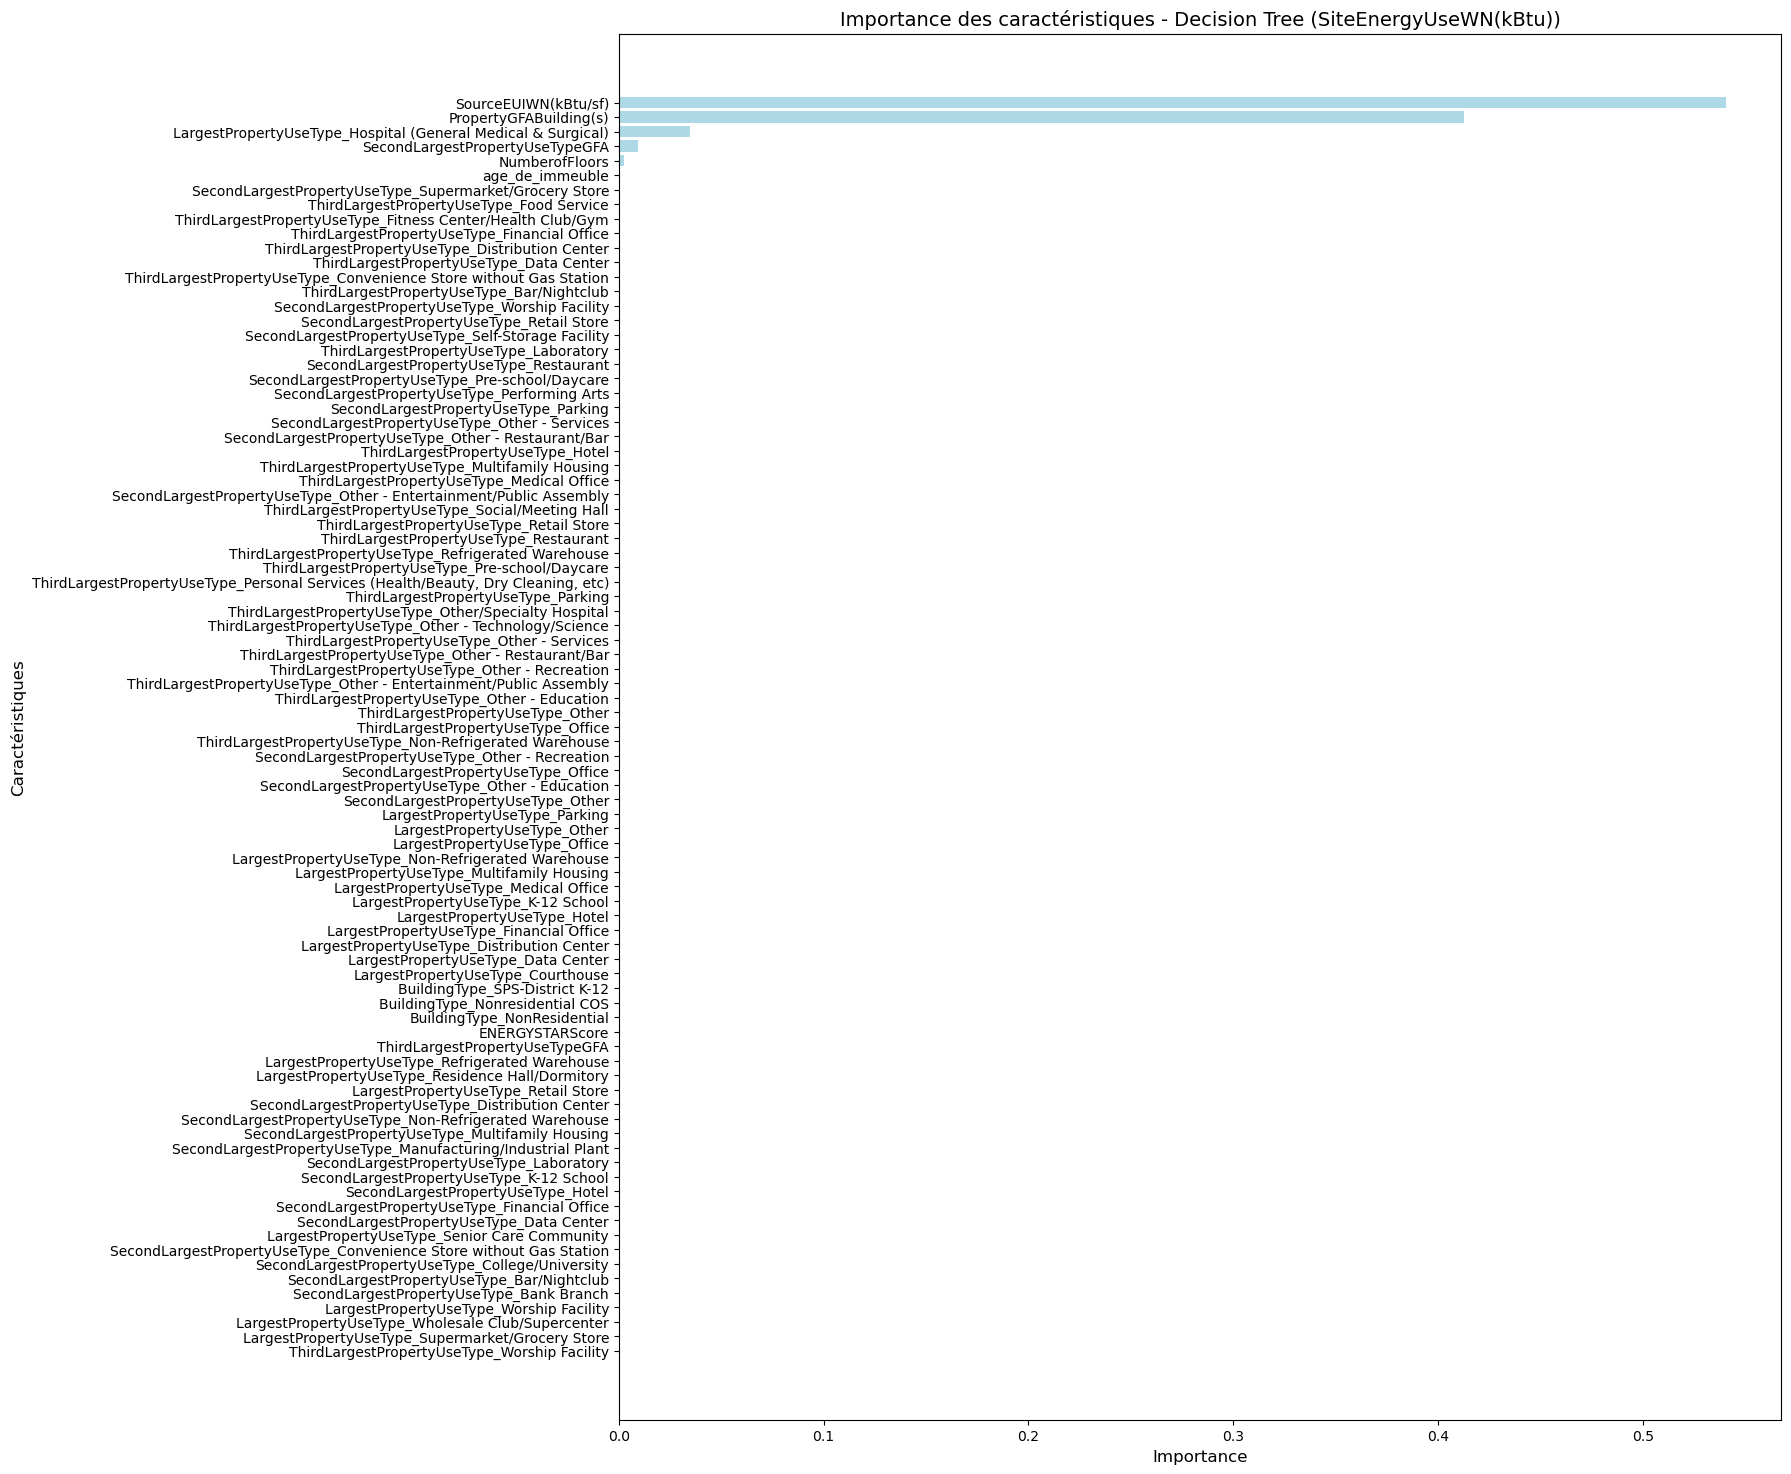

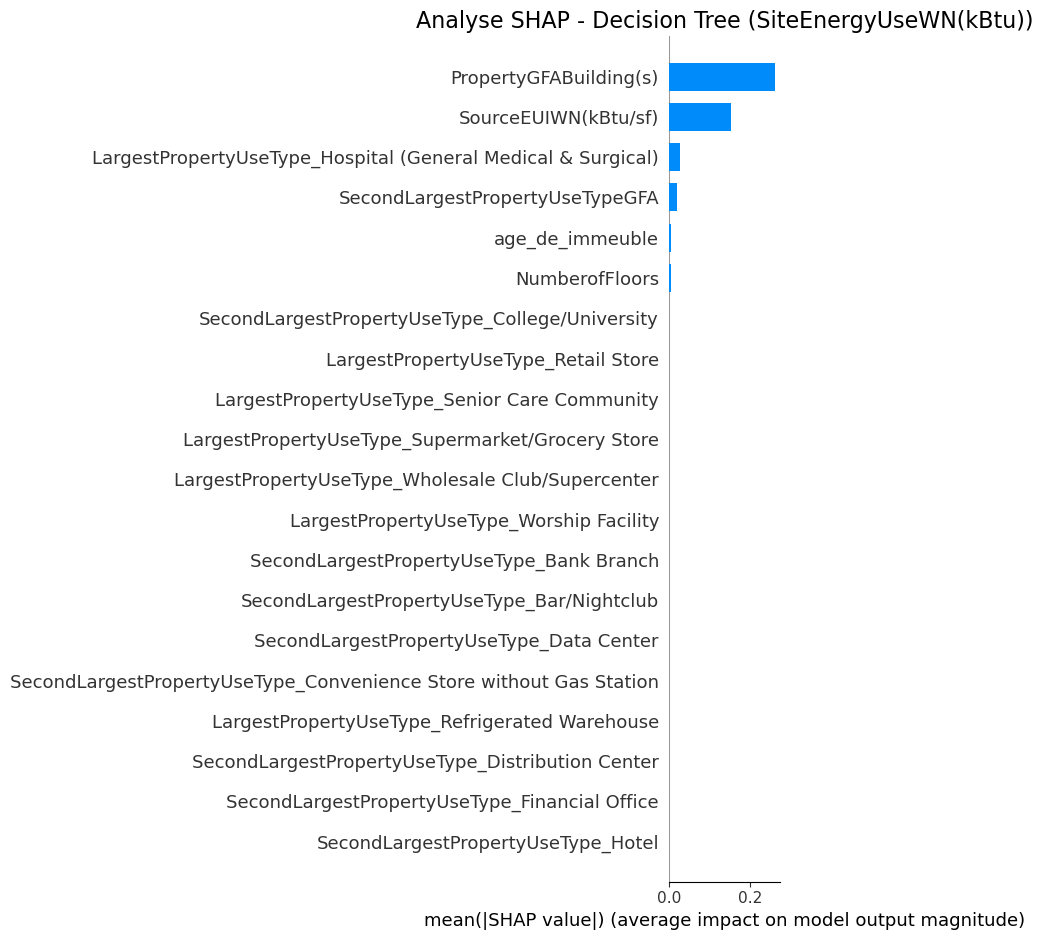

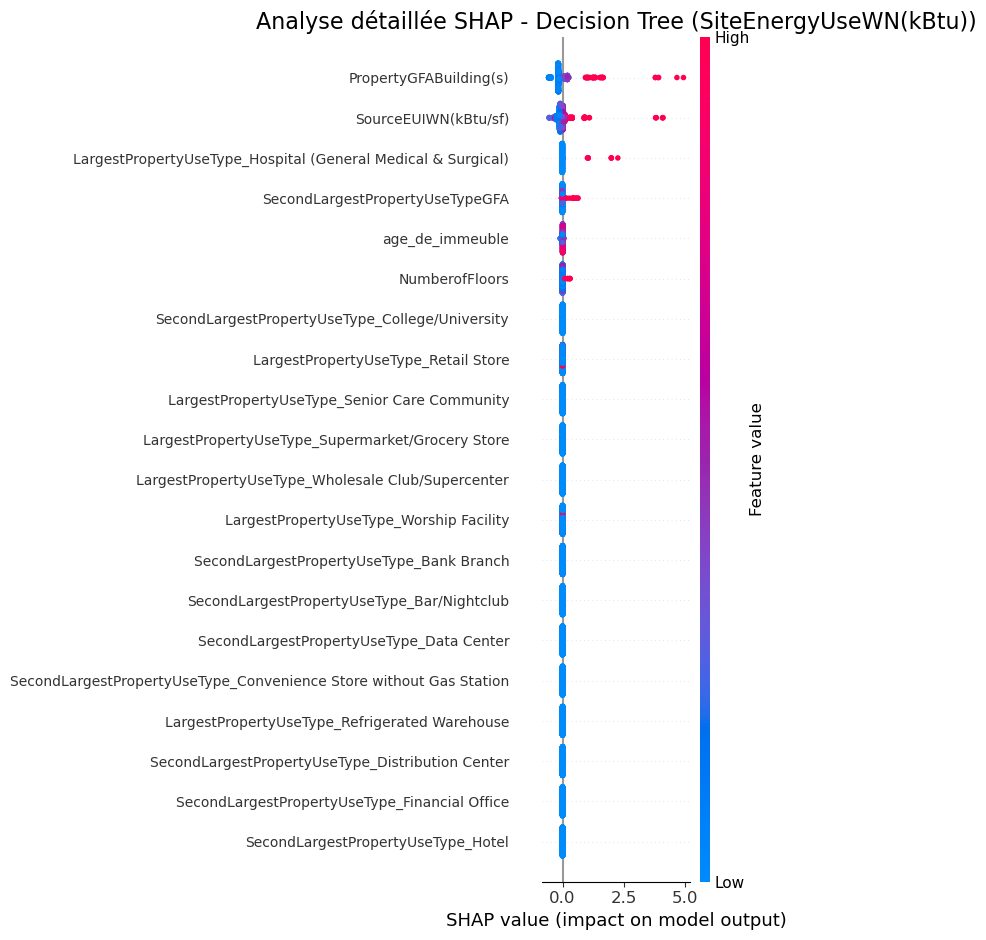

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import shap

# --- Analyse de l'importance des caractéristiques pour "SiteEnergyUseWN(kBtu)" avec Decision Tree ---

# Meilleurs hyperparamètres optimisés pour Decision Tree
best_params = {
    'max_depth': 5,
    'min_samples_split': 10,
    'min_samples_leaf': 4
}

# Définir la cible unique
target = 'SiteEnergyUseWN(kBtu)'

# Extraire les données spécifiques
target_idx = list(y.columns).index(target)  # Trouver l'index de la colonne cible
y_train_target = y_train[:, target_idx]  # Extraire les valeurs de la cible

# Entraîner le modèle Decision Tree pour cette cible
dt_model = DecisionTreeRegressor(**best_params, random_state=42)
dt_model.fit(X_train, y_train_target)

# Importance des caractéristiques avec Decision Tree
dt_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(15, 18))
plt.barh(dt_importance['Feature'], dt_importance['Importance'], color='lightblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Caractéristiques', fontsize=12)
plt.title(f'Importance des caractéristiques - Decision Tree ({target})', fontsize=14)
plt.gca().invert_yaxis()  # Inverser l'axe Y pour afficher les plus importantes en haut
plt.show()

# --- Analyse SHAP pour le modèle Decision Tree ---

# SHAP explainer pour Decision Tree
dt_explainer = shap.Explainer(dt_model, X_train)
shap_values_dt = dt_explainer(X_train)

# Graphique de résumé SHAP (barres)
plt.figure(figsize=(15, 18))
shap.summary_plot(shap_values_dt, X_train, plot_type='bar', show=False)
plt.title(f'Analyse SHAP - Decision Tree ({target})', fontsize=16)
plt.tight_layout()
plt.show()

# Graphique de résumé SHAP détaillé avec labels réduits
plt.figure(figsize=(14, 10))  # Augmenter la taille du graphique
shap.summary_plot(shap_values_dt, X_train, show=False)
plt.title(f'Analyse détaillée SHAP - Decision Tree ({target})', fontsize=16)

# Réduire la taille des labels des variables sur l'axe Y
plt.yticks(fontsize=10)  # Ajuste la taille des noms des variables
plt.xticks(fontsize=12)  # Ajuste la taille des valeurs sur l'axe X

plt.tight_layout()
plt.show()


# Analyse de l'importance des caractéristiques pour "TotalGHGEmissions" avec Bayesian Ridge Regression

In [28]:
# Vérifions la structure de y_train
print(type(y_train))  # Type de y_train
print(y_train.shape)  # Forme de y_train


<class 'numpy.ndarray'>
(694, 2)


In [29]:
# Si 'TotalGHGEmissions' est la première colonne (index 0)
y_train_target = y_train[:, 0]  # Accède à la première colonne (index 0)

# Si 'TotalGHGEmissions' est la deuxième colonne (index 1)
y_train_target = y_train[:, 1]  # Accède à la deuxième colonne (index 1)


In [30]:
print(y_train_target.shape)  # Cela devrait afficher (694,) si c'est un vecteur 1D.


(694,)


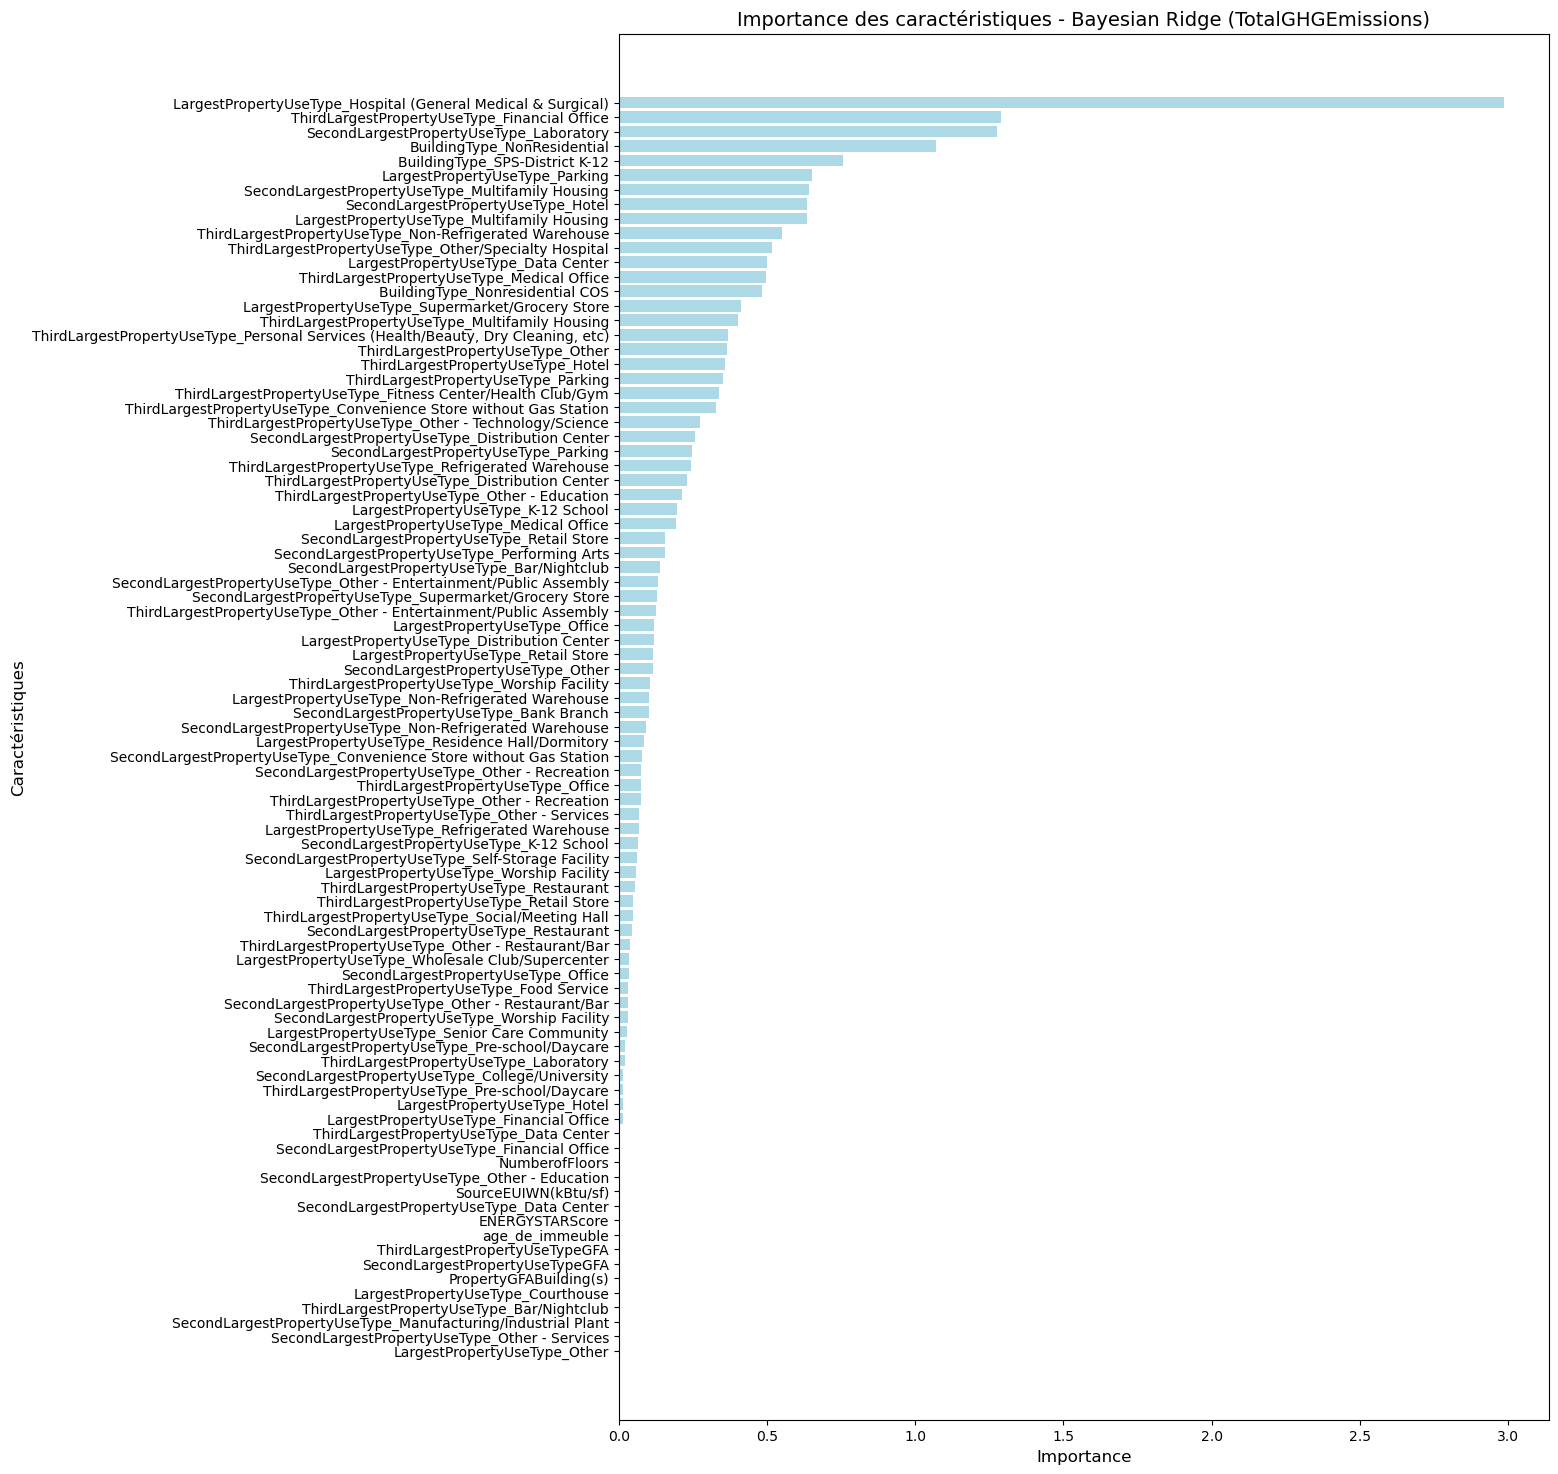

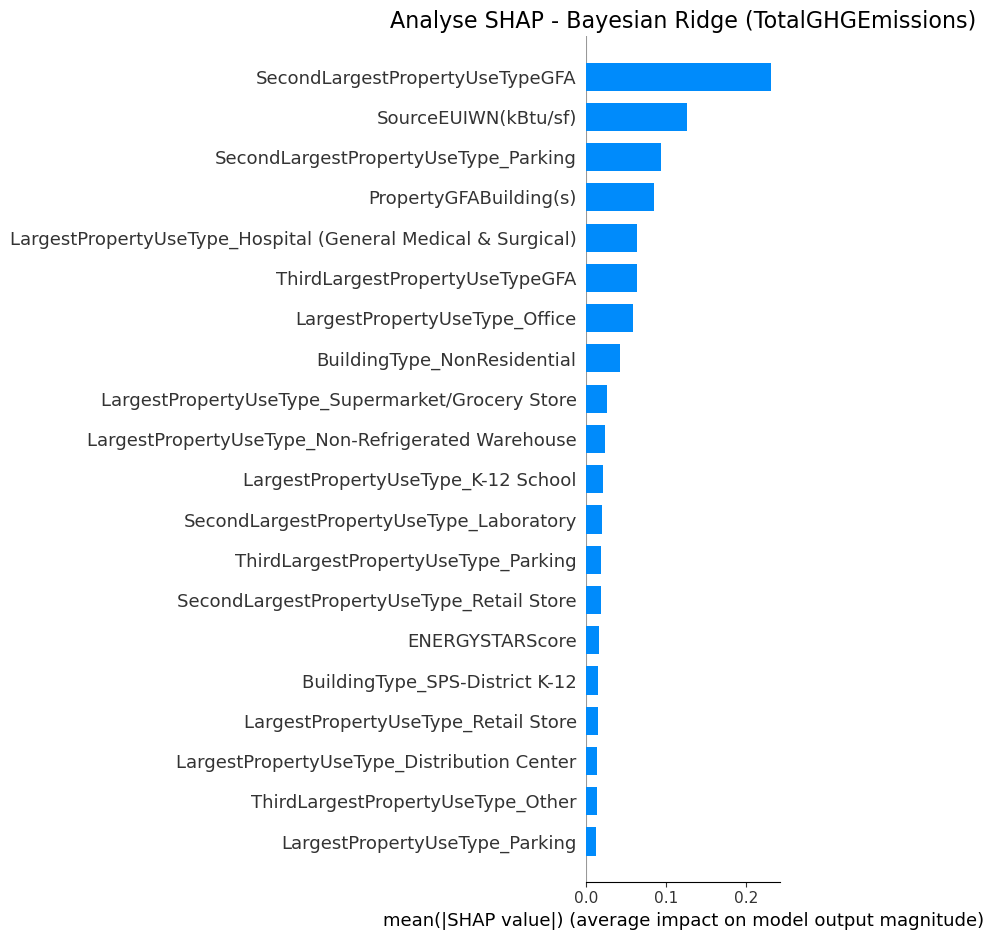

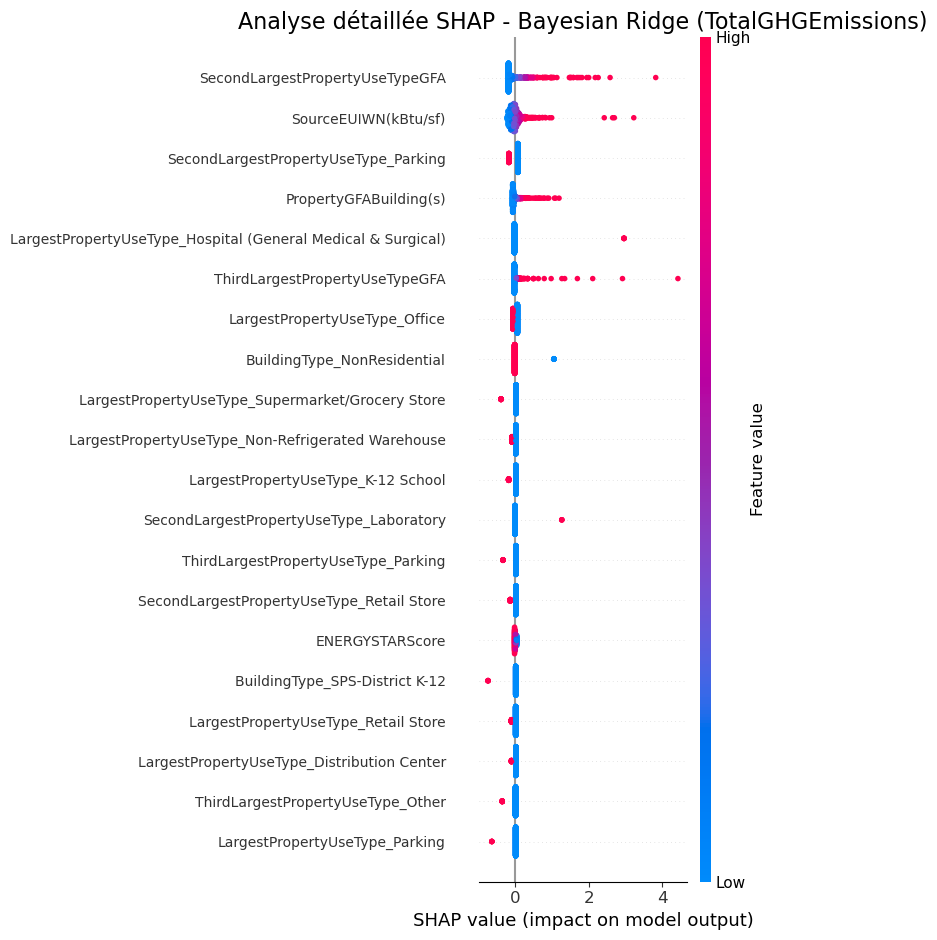

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import BayesianRidge
import shap

# Cible : 'TotalGHGEmissions'
target = 'TotalGHGEmissions'

# Si 'TotalGHGEmissions' est la première colonne (index 0)
y_train_target = y_train[:, 0]  # Extraire la première colonne (index 0)

# Entraîner le modèle Bayesian Ridge pour cette cible
best_params = {
    'alpha_1': 1e-6,
    'alpha_2': 1e-6,
    'lambda_1': 1e-6,
    'lambda_2': 1e-6
}

# Entraîner le modèle Bayesian Ridge avec les données d'entraînement
bayesian_ridge_model = BayesianRidge(**best_params)
bayesian_ridge_model.fit(X_train, y_train_target)  # Ici, y_train_target est une 1D array

# Importance des caractéristiques avec Bayesian Ridge
# Utilisation des coefficients du modèle pour mesurer l'importance des caractéristiques
bayesian_ridge_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(bayesian_ridge_model.coef_)
}).sort_values(by='Importance', ascending=False)

# Tracer l'importance des caractéristiques
plt.figure(figsize=(12, 18))
plt.barh(bayesian_ridge_importance['Feature'], bayesian_ridge_importance['Importance'], color='lightblue')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Caractéristiques', fontsize=12)
plt.title(f'Importance des caractéristiques - Bayesian Ridge ({target})', fontsize=14)
plt.gca().invert_yaxis()  # Inverser l'axe Y pour afficher les plus importantes en haut
plt.show()

# --- Analyse SHAP pour le modèle Bayesian Ridge Regression ---

# Créer un explainer SHAP pour Bayesian Ridge
bayesian_ridge_explainer = shap.Explainer(bayesian_ridge_model, X_train)

# Calculer les valeurs SHAP pour l'ensemble d'entraînement
shap_values_bayesian = bayesian_ridge_explainer(X_train)

# Graphique de résumé SHAP (barres)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_bayesian, X_train, plot_type='bar', show=False)
plt.title(f'Analyse SHAP - Bayesian Ridge ({target})', fontsize=16)
plt.tight_layout()
plt.show()

# Graphique de résumé SHAP détaillé avec labels réduits
plt.figure(figsize=(14, 10))  # Augmenter la taille du graphique
shap.summary_plot(shap_values_bayesian, X_train, show=False)
plt.title(f'Analyse détaillée SHAP - Bayesian Ridge ({target})', fontsize=16)

# Réduire la taille des labels des variables sur l'axe Y
plt.yticks(fontsize=10)  # Ajuste la taille des noms des variables
plt.xticks(fontsize=12)  # Ajuste la taille des valeurs sur l'axe X

plt.tight_layout()
plt.show()


# 7.2.1 ) predictions individuelles 

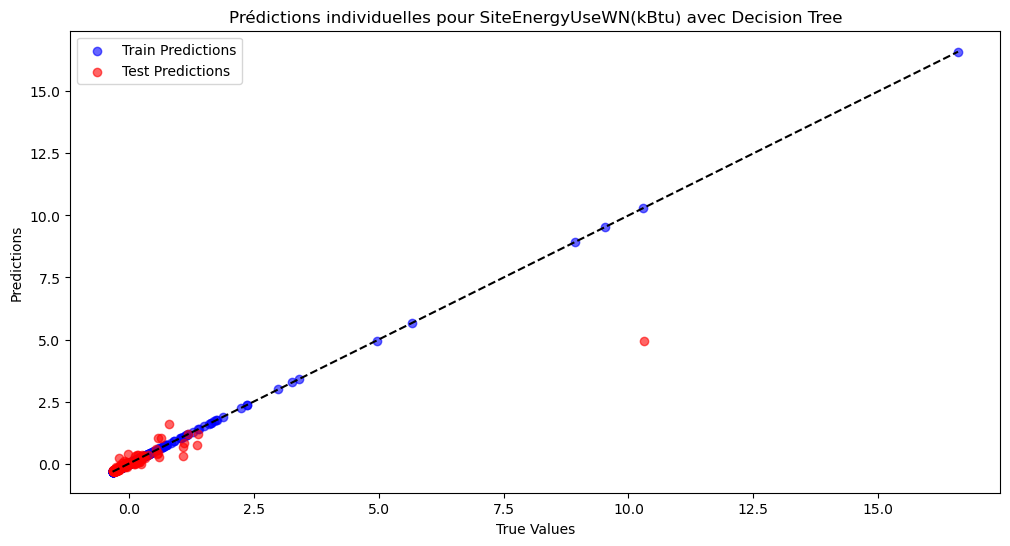

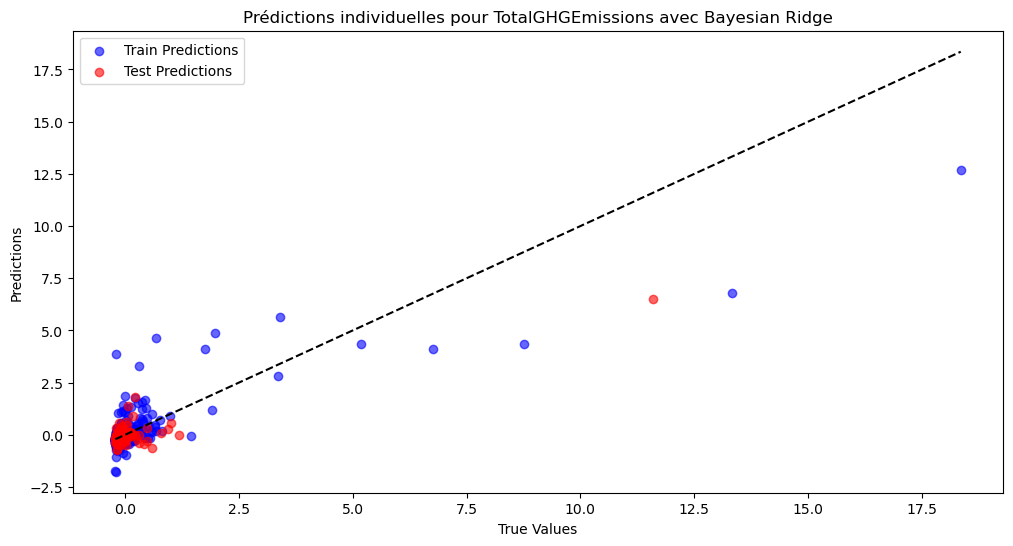

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

# --- Prédictions et graphes pour chaque cible avec leur modèle respectif ---

# 1. Prédictions pour la cible "SiteEnergyUseWN(kBtu)" avec Decision Tree Regressor
target_1 = 'SiteEnergyUseWN(kBtu)'

# Si y_train est un ndarray, on accède à la bonne colonne
# Index de la cible dans y_train (par exemple, 0 pour la première colonne)
target_1_index = 0  # Remplacer par l'index correct si nécessaire

y_train_target_1 = y_train[:, target_1_index]
y_test_target_1 = y_test[:, target_1_index]

# Entraîner le modèle Decision Tree pour cette cible
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train_target_1)

# Prédictions sur les données d'entraînement et de test
y_train_pred_1 = tree_model.predict(X_train)
y_test_pred_1 = tree_model.predict(X_test)

# Graphique des prédictions pour "SiteEnergyUseWN(kBtu)"
plt.figure(figsize=(12, 6))
plt.scatter(y_train_target_1, y_train_pred_1, color='blue', label='Train Predictions', alpha=0.6)
plt.scatter(y_test_target_1, y_test_pred_1, color='red', label='Test Predictions', alpha=0.6)
plt.plot([min(y_train_target_1), max(y_train_target_1)], [min(y_train_target_1), max(y_train_target_1)], color='black', linestyle='--')  # Ligne de prédiction parfaite
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Prédictions individuelles pour {target_1} avec Decision Tree')
plt.legend()
plt.show()

# 2. Prédictions pour la cible "TotalGHGEmissions" avec Bayesian Ridge Regression
target_2 = 'TotalGHGEmissions'

# Si y_train est un ndarray, on accède à la bonne colonne
# Index de la cible dans y_train (par exemple, 1 pour la deuxième colonne)
target_2_index = 1  # Remplacer par l'index correct si nécessaire

y_train_target_2 = y_train[:, target_2_index]
y_test_target_2 = y_test[:, target_2_index]

# Entraîner le modèle Bayesian Ridge pour cette cible
bayesian_ridge_model = BayesianRidge()
bayesian_ridge_model.fit(X_train, y_train_target_2)

# Prédictions sur les données d'entraînement et de test
y_train_pred_2 = bayesian_ridge_model.predict(X_train)
y_test_pred_2 = bayesian_ridge_model.predict(X_test)

# Graphique des prédictions pour "TotalGHGEmissions"
plt.figure(figsize=(12, 6))
plt.scatter(y_train_target_2, y_train_pred_2, color='blue', label='Train Predictions', alpha=0.6)
plt.scatter(y_test_target_2, y_test_pred_2, color='red', label='Test Predictions', alpha=0.6)
plt.plot([min(y_train_target_2), max(y_train_target_2)], [min(y_train_target_2), max(y_train_target_2)], color='black', linestyle='--')  # Ligne de prédiction parfaite
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title(f'Prédictions individuelles pour {target_2} avec Bayesian Ridge')
plt.legend()
plt.show()
